In [2]:
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
img = cv2.imread('./test_images/beautiful-ginger-woman-casual-purple-t-shirt-looks-with-pleased-delighted-expression-camera-poses-against-white-concrete-wall_273609-3734.avif')
img.shape

(493, 740, 3)

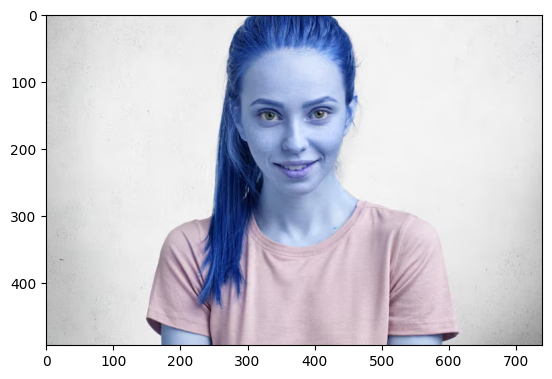

In [7]:
plt.imshow(img)

In [8]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray.shape

(493, 740)

In [9]:
gray

array([[198, 189, 191, ..., 226, 225, 225],
       [196, 190, 191, ..., 226, 225, 225],
       [194, 191, 191, ..., 226, 225, 225],
       ...,
       [191, 178, 171, ..., 152, 148, 146],
       [188, 176, 170, ..., 153, 149, 148],
       [185, 176, 171, ..., 153, 145, 127]], shape=(493, 740), dtype=uint8)

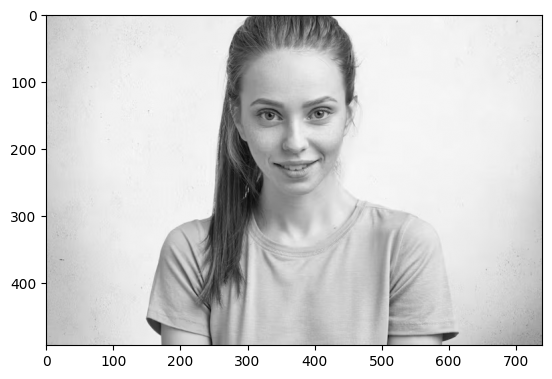

In [11]:
plt.imshow(gray, cmap='gray')

In [13]:
face_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_frontalface_default.xml')
eyes_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_eye.xml')

faces = face_cascade.detectMultiScale(gray, 1.3, 5)
faces

array([[268,  67, 209, 209]], dtype=int32)

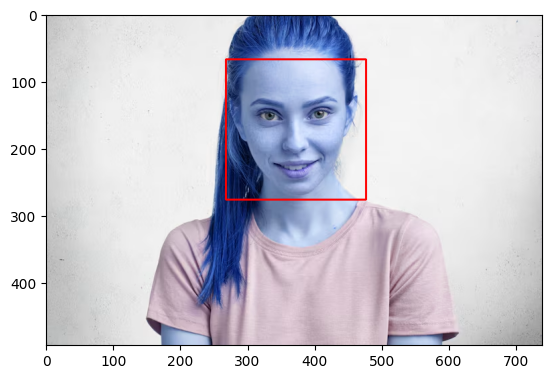

In [15]:
(x,y,w,h) = faces[0]
x,y,w,h
face_img = cv2.rectangle(img, (x,y), (x+w,y+h), (255,0,0), 2)
plt.imshow(face_img)

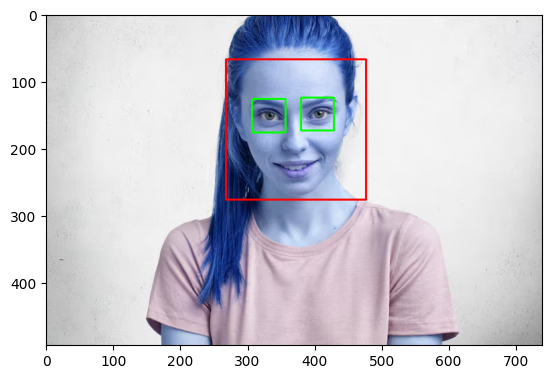

In [16]:
cv2.destroyAllWindows()
for (x,y,w,h) in faces:
    face_img = cv2.rectangle(img, (x,y), (x+w,y+h), (255,0,0), 2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = face_img[y:y+h, x:x+w]
    eyes = eyes_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
        

plt.figure()
plt.imshow(face_img, cmap='gray')
plt.show()